# sources

https://github.com/openai/CLIP/blob/fcab8b6eb92af684e7ff0a904464be7b99b49b88/notebooks/Prompt_Engineering_for_ImageNet.ipynb
https://github.com/openai/CLIP#zero-shot-prediction

# Install the clip package and its dependencies


In [1]:
# remove # to download packages

! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-7l_mt5_s
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-7l_mt5_s
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done


In [2]:
# Import packages

import os
import numpy as np
import torch
import clip
from tqdm.notebook import tqdm
from pkg_resources import packaging
from torch.utils.data import Subset
from matplotlib import pyplot as plt

In [3]:
# available CLIP models
# In this experiment, ViT-L/14@336px is used, as this is also the default model in the original CLIP paper
print(clip.available_models())

# Loading in model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-L/14@336px', device)

['RN50', 'RN101', 'RN50x4', 'RN50x16', 'RN50x64', 'ViT-B/32', 'ViT-B/16', 'ViT-L/14', 'ViT-L/14@336px']


100%|███████████████████████████████████████| 891M/891M [00:11<00:00, 79.6MiB/s]


In [4]:
# Parameters model

input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 427,944,193
Input resolution: 336
Context length: 77
Vocab size: 49408


# MNIST

In [5]:
# Import MNIST dataset

from torchvision.datasets import  MNIST


In [6]:
# Loading in MNIST train set
# Make sure train is set to true
# Train set contains 60.000 images
mnist_train = MNIST(root=os.path.expanduser("~/.cache"), download=True, train=True)

# Loading in MNIST test set
# Test set contains 10.000 images
mnist_test = MNIST(root=os.path.expanduser("~/.cache"), download=True, train=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 99640775.07it/s]


Extracting /root/.cache/MNIST/raw/train-images-idx3-ubyte.gz to /root/.cache/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 38273520.96it/s]


Extracting /root/.cache/MNIST/raw/train-labels-idx1-ubyte.gz to /root/.cache/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 26968427.40it/s]


Extracting /root/.cache/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/.cache/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 3233287.30it/s]


Extracting /root/.cache/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.cache/MNIST/raw



In [7]:
# Inspecting number of data points in each set
# Check whether all train and test images are loaded in

print(mnist_train)
print(mnist_test)

Dataset MNIST
    Number of datapoints: 60000
    Root location: /root/.cache
    Split: Train
Dataset MNIST
    Number of datapoints: 10000
    Root location: /root/.cache
    Split: Test


In [8]:
# Takes long to run code on 60.000 images
# To test run code on smaller batch, subset of training data is created, containing 10% of the original dataset
# Subset of training dataset (10%, or 6000 0f the 60.000 datsets )

subset_mnist_train = Subset(mnist_train, indices=range(len(mnist_train) // 10))

# Creating image and word embeddings

In [9]:
# Defining classes
mnist_classes = ['0','1','2','3','4','5','6','7','8','9',]
class_map = {'mnist': mnist_classes}

# Defining prompts
# Experiment with different prompts, as the entire prompt is encoded
# and will influence how similar the image and text embedding are
mnist_templates = ['a photo of the number: "{}".',]
template_map = {'mnist': mnist_templates}

In [10]:
# Function to calculate accuracy

@torch.no_grad()
def accuracy(output, target, topk=(1,)):
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.reshape(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)

        res.append(correct_k.mul_(100.0 / batch_size).item())
    return res

In [11]:
# Function to create text embeddings

@torch.no_grad()
def extract_text_features(dataset_name):
    class_names = class_map[dataset_name]
    templates = template_map[dataset_name]
    model.to(device)
    model.eval()

    zeroshot_weights = []
    for classname in class_names:
        texts = [template.format(classname) for template in templates]
        texts = clip.tokenize(texts).to(device)
        class_embeddings = model.encode_text(texts)
        # embedding size = 768,  (= dimensionality of the encoder layers)
        # each template + class gets vector of length 768
        # size of tensor is (x, 768), x refers to the number of templates included
        # x = rows, 768 = columns
        class_embeddings /= class_embeddings.norm(dim=-1, keepdim=True)
        # normalized over rows (Frobenius Norm)
        # dimension remains (x, 768)
        class_embedding = class_embeddings.mean(dim=0)
        # Column wise mean is calculated
        # Vector of length 768 remains
        class_embedding /= class_embedding.norm()
        # vector is normalized (Frobenius normalization)
        zeroshot_weights.append(class_embedding)
        # every input (class + every possible template => mean) is represented as embedding of length 768
        # In this case, list of 10 embeddings with length 768
    zeroshot_weights = torch.stack(zeroshot_weights, dim=1).to(device)
    # list of embeddings is concatenated in matrix
    # embeddings are joined on column level

    torch.set_printoptions(profile="full")
    return zeroshot_weights

In [12]:
image_features = []
image_labels = []
# !! Loading in the data: images + ground truth label (HAVE TO BE LOADED IN IN THE SAME ORDER)
for image, class_id in subset_mnist_train:
    # Preprocess: pixel intensity is normalized using dataset mean and standard deviation.
    # Input images are resized and center-cropped to conform with the expected image resolution.
    image_input = preprocess(image).unsqueeze(0).to(device)
    # unsqueeze(x), returns a new tensor with a dimension of size one inserted at the specified position.
    # x refers to the index at which to insert the singleton dimension

    with torch.no_grad():
        image_feature = model.encode_image(image_input)
        # matrix with dimenension (1, 768)

    image_feature /= image_feature.norm()
    # image features are normalized, if dim is None, the norm is calculated across all dimensions of input

    image_features.append(image_feature)
    # list of embedding (length 768) for each image
    image_labels.append(class_id)
    # Class id (the factorized ground truth) is added in a list of tensors

In [13]:
image_features = torch.stack(image_features, dim=-1).to(device)
# separate embeddings are concatenated on the second of 2 dimensions, (so on rows)
# The final matrix has the shape [768, 10]

# Squeeze to get a tensor returned with all the dimensions of input of size 1 removed
image_features = image_features.squeeze()

In [14]:
# extract text feature
text_features = extract_text_features('mnist')

In [15]:
# compute top-1 accuracy
logits = (100. * image_features.T @ text_features).softmax(dim=-1)
# image features are multiplied by text features, softmax converts real numbers into probability distribution
# Output tensor lies in range 0-1 and sums to 1
image_labels = torch.tensor(image_labels).unsqueeze(dim=1).to(device)

top1_acc = accuracy(logits, image_labels, (1,))

print(f'top-1 accuracy for = dataset: {top1_acc[0]:.3f}')

top-1 accuracy for = dataset: 81.400


# Visualizing highest scoring image

In [20]:
target_number = input("which number are you looking for? ")

which number are you looking for? 9


Best Image Class ID: 9


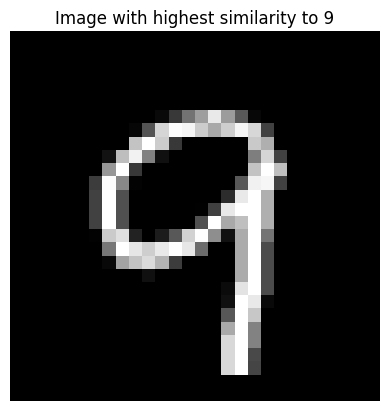

In [21]:
# Generate the text prompt for the target number
target_text = template_map['mnist'][0].format(target_number)
target_text = clip.tokenize([target_text]).to(device)

# Encode the text prompt to get its feature
target_text_feature = model.encode_text(target_text)
target_text_feature /= target_text_feature.norm()

# Transpose the image features for compatibility
transposed_image_features = image_features.T

# Calculate similarity scores for each image
similarity_scores = transposed_image_features @ target_text_feature.T

# Find the index of the image with the highest similarity score
best_image_index = torch.argmax(similarity_scores)

# Retrieve the corresponding image
best_image = subset_mnist_train[best_image_index][0]

# Print the class ID of the best image
best_image_class_id = subset_mnist_train[best_image_index][1]
print("Best Image Class ID:", best_image_class_id)

# Convert the PIL Image to a NumPy array
best_image_np = np.array(best_image)

# Display the best image
plt.imshow(best_image_np, cmap='gray')  # Assuming it's a grayscale image
plt.title(f"Image with highest similarity to {target_number}")
plt.axis('off')  # Turn off axis labels
plt.show()

